In [3]:
import os
from gpuutils import GpuUtils
GpuUtils.allocate(gpu_count=1, framework='keras')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True) 

GPU 1  will be allocated


In [2]:
from matplotlib import pyplot as plt
import numpy as np
#import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, UpSampling1D
from keras_flops import get_flops

In [17]:
def normalizing_data(signal, noise):
  """
    This function normalize the data using mean and standard
    deviation from noise data
  """
  std = np.std(noise)
  mean = np.mean(noise)
  normalized_noise = (noise - mean)/std
  normalized_signal = (signal - mean)/std
  
  return normalized_noise, normalized_signal, std, mean

In [18]:
def unnormalizing_data(normalized_data, std, mean):
  data = normalized_data*std + mean
  return data

In [19]:
def load_data(all_signals=True):
  """
    This function loads data from ARIANNA group, downloaded localy
    Args:
     all_signals = True means that all the signals are
    used in the test data. If all_signals = False only 20000 signals are used as test data.
    Can be useful if training on signals aswell or just want to test data on small
    test data.
    Returns:
      x_test, y_test, smask_test, signal, noise, std, mean
    
  """
  DATA_URL = '/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_0000.npy'#/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_0000.npy
  noise = np.load(DATA_URL)

  for i in range(1,10):
    noise = np.vstack((noise,np.load(f'/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_000{i}.npy')))

  noise = np.vstack((noise,np.load('/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_0010.npy')))
  signal = np.load("/home/halin/Autoencoder/Data/trimmed100_data_signal_3.6SNR_1ch_0000.npy")
  signal = np.vstack((signal,np.load("/home/halin/Autoencoder/Data/trimmed100_data_signal_3.6SNR_1ch_0001.npy")))
  n_classes = 2
 
  noise, signal, std, mean = normalizing_data(signal, noise)

  shuffle = np.arange(noise.shape[0], dtype=np.int)
  np.random.shuffle(shuffle)
  noise = noise[shuffle]
  shuffle = np.arange(signal.shape[0], dtype=np.int)
  np.random.shuffle(shuffle)
  signal = signal[shuffle]

  number_of_test_samples = 0
  if all_signals:
    number_of_test_samples = len(signal)
  else:  
    number_of_test_samples = 20000

  

  signal_test = signal[:number_of_test_samples]
  noise_test = noise[:number_of_test_samples*2]
  
  signal = signal[number_of_test_samples:]
  noise = noise[number_of_test_samples*2:]

  x_test = np.vstack((noise_test, signal_test))
  x_test = np.expand_dims(x_test, axis=-1)
  y_test = np.ones(len(x_test))
  y_test[:len(noise_test)] = 0
  shuffle = np.arange(x_test.shape[0])  #, dtype=np.int
  np.random.shuffle(shuffle)
  x_test = x_test[shuffle]
  y_test = y_test[shuffle]
  smask_test = y_test == 1

  return x_test, y_test, smask_test, signal, noise, std, mean

In [15]:
x_test, y_test, smask_test, signal, noise, std, mean = load_data(all_signals=False)

In [8]:
path = '/home/halin/Autoencoder/Models/complement_models/best_model.h5'
model = load_model(path)

In [9]:
def plot_signal(x):
  for item in x:
    fig, ax = plt.subplots(1,1)
    ax.plot(item)
    fig.tight_layout()
    plt.show()

In [12]:
def find_signal(model, treshold, x, smask, under_treshold=True):
  """
    This function steps trough the losses to find data tha are
    below or above a sertain treshold.
    Args:
      model: keras model
      treshold: (float) value to compare
      x: data to test
      smask: where the true signals are
      under_treshold: (bool)
    Returns:
      outliers: the data beyond threshold in an list

  """
  outliers = []
  for i in range(len(x)):
    x_pred = model.predict(np.array([x[i],]))
    test = x[i]
    
    pred_loss = keras.losses.mean_squared_error(x[i], x_pred)
    pred_loss = np.sum(pred_loss)/len(pred_loss)
    if under_treshold:
      if pred_loss < treshold:
        outliers.append(x[i])
        
    else:
      if pred_loss > treshold:
        outliers.append(x[i])  
  return outliers      

   

In [ ]:
outliers = find_signal(model, 0.001, x_test, smask_test, True)

In [16]:
print(len(outliers))

23


In [5]:
# Load models
def load_models(path):
  """
    This function search for keras models in an folder and loads
    it to a list en returns a list of models. Models which contains 
    the substring "best_model" are excluded.
    Args:
      path: were to search for models
  """
  
  import glob
  list_of_models = glob.glob(path + '/*.h5')
  models = []
  
  for i, path in enumerate(list_of_models):
    if 'best_model' in path:
      pass
    else: 
      models.append(load_model(path))

  return models

In [21]:
def prep_loss_values(model, x, smask):
  """
    This function predict the value using keras.predict and
    calculates the mse for signals and noise events. Add the values 
    and divide by sample size
    Args:
      model: keras model
      x: the test data shape (Any, 100, 1)
      smask: smask for x 
    Returns: 
      signal_loss, noise_loss 
  """
  data_bins = np.size(x[0])
  x_noise = x[~smask]
  x_pred_noise = model.predict(x_noise)
  x_signal = x[smask]
  x_pred_signal = model.predict(x_signal)
  noise_loss = keras.losses.mean_squared_error(x_noise, x_pred_noise)
  noise_loss = np.sum(noise_loss, axis=1)/data_bins     #Per sample bin

  signal_loss = keras.losses.mean_squared_error(x_signal, x_pred_signal)
  signal_loss = np.sum(signal_loss, axis=1)/data_bins

  return signal_loss, noise_loss

In [7]:
# Noise reduction curve multi models
def noise_reduction_curve_multi_models(models, path, fpr, plot=True, x_low_lim=0.8, save_outputs=True, models_to_plot=[]):
  """
    This function takes signal and noise loss as arguments. They are 
    arrays from mse calculating.
    Bins is taken from hist
    Args: 
      models: a list of keras models
      path: where the plots saves
      fpr: False Positive Rate 
      x_low_lim: limit for lowest x value on plot (highest=1)
    Returns:
      thershold: value for a specific False Positive Ratio fpr for best model
      tpr: True positive ratio for best model
      fpr: False positive ratio for best model
      tnr: True negative ratio for best model
      fnr: False negative ratio for best model
      results[0][4]: noise reduction factor for first model

  """
  number_of_models = len(models)
  results = [0]*number_of_models
  for j in range(number_of_models):
    
    model = models[j]
    not_found_treshold_value = True
    signal_loss, noise_loss = prep_loss_values(model, x_test, smask_test)
    
    max_value = np.max(signal_loss)
    min_value = np.min(noise_loss)
    low_lim = np.floor(np.log10(min_value))
    high_lim = np.floor(np.log10(max_value))
    bins = np.logspace(low_lim,high_lim , 1000)


    threshold_value = 0
    true_pos = np.zeros(len(bins))
    false_pos = np.zeros(len(bins))
    true_neg = np.zeros(len(bins))
    false_neg = np.zeros(len(bins))
    noise_reduction_factor = np.zeros(len(bins))


    tpr = 0
    for i, limit in enumerate(bins):
    
      true_pos[i] = np.count_nonzero(signal_loss > limit)/len(signal_loss)
      false_pos[i] =np.count_nonzero(noise_loss > limit)/len(noise_loss)
      true_neg[i] = 1 - false_pos[i]
      false_neg[i] = 1 - true_pos[i]
    

      if (true_neg[i] < 1):
        noise_reduction_factor[i] = 1 / ( 1 - true_neg[i])
      else:
        noise_reduction_factor[i] = len(noise_loss)  
      
      
      if false_pos[i] < fpr and not_found_treshold_value:
        threshold_value = limit
        tpr = true_pos[i]
        not_found_treshold_value = False
        


    fnr = 1 - tpr
    tnr = 1 - fpr
    

    results[j] = [true_pos, true_neg, false_pos, false_neg, noise_reduction_factor]

    

  
  if plot:
    if len(models_to_plot) < 1:
      models_to_plot = np.arange(0,len(models))

    for k in models_to_plot:
      model_name = 'model ' + str(k+1)
      plt.plot(results[k][0],results[k][4], label=model_name)  
      
    noise_events = np.count_nonzero(~smask_test)

    plt.legend()
    plt.ylabel(f'Noise reduction factor. Total {noise_events} noise events')
    plt.xlabel('Efficiency/True Positive Rate')
    plt.title('Signal efficiency vs. noise reduction factor')
    plt.semilogy(True)
    plt.xlim(x_low_lim,1)
    plt.grid()
    if len(models) > 1:
      path = path + '/Signal_efficiency_vs_noise_reduction_factor_all_models.png'
    else:
      path = path + '_Signal_efficiency_vs_noise_reduction_factor.png'  
    plt.tight_layout()
    if save_outputs:
      plt.savefig(path)

    plt.show()
  # plt.plot(false_pos, true_pos)
  # plt.show()

  return threshold_value, tpr, fpr, tnr, fnr, results[0][4]

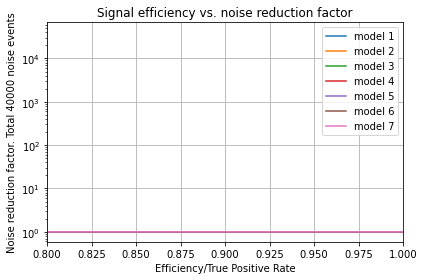

In [22]:
path = '/home/halin/Autoencoder/Models/CNN_002'
models = load_models(path)
_ = noise_reduction_curve_multi_models(models, path, fpr=0.05, save_outputs=False )